### Advanced task: image captioning with visual attention

![img](https://i.imgur.com/r3r0fS4.jpg)

__This task__ walks you through all steps required to build an attentive image-to-captioning system. Except this time, there's no `<YOUR CODE HERE>`'s. You write all the code.

You are free to approach this task in any way you want. Follow our step-by-step guide or abandon it altogether. Use the notebook or add extra .py files (remember to add them to your anytask submission). The only limitation is that your code should be readable and runnable top-to-bottom.



### Step 1: image preprocessing (5 pts)

First, you need to prepare images for captioning. Just like in the basic notebook, you are going to use a pre-trained image classifier from the model zoo. Let's go to the [`preprocess_data.ipynb`](./preprocess_data) notebook and change a few things there. This stage is mostly running the existing code with minor modiffications.

1. Download the data someplace where you have enough space. You will need around 100Gb for the whole thing.
2. Pre-compute and save Inception activations at the layer directly __before the average pooling__.
 - the correct shape should be `[batch_size, 2048, 8, 8]`. Your LSTM will attend to that 8x8 grid.


__Note 1:__ Inception is great, but not the best model in the field. If you have enough courage, consider using ResNet or DenseNet from the same model zoo. Just remember that different models may require different image preprocessing.

__Note 2:__ Running this model on CPU may take days. You can speed things up by processing data in parts using colab + google drive. Here's how you do that: https://colab.research.google.com/notebooks/io.ipynb

**Answer:**

Looks like it has already been done in the `preprocess_data.ipynb` notebook.
I decided to proceed with the `Inception3` model.

Here are some more details:
- `./data/image_codes.npy` stores all vectors
- `./data/image_logits.npy` stores all logits
- `./data/captions.json` contains captions
- `.data/captions_tokenized.json` contains tokenized captions

As for the activations **before the average pooling** I had to split it into three parts:
- image_codes_for_attn_part1.npy (0 to 999 batches, 32000 images)
- image_codes_for_attn_part2.npy (1000 to 1999 batches, 32000 images)
- image_codes_for_attn_part3.npy (2000 to 2999 batches, 32000 images)
- image_codes_for_attn_part4.npy (3000 to 3697 batches, 22287 images)

### Step 2: sub-word tokenization (5 pts)

While it is not strictly necessary for image captioning, you can generally improve generative text models by using sub-word units. There are several sub-word tokenizers available in the open-source (BPE, Wordpiece, etc).

* __[recommended]__ BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory on how it works: https://arxiv.org/abs/1508.07909
* We recommend starting with __4000 bpe rules__.
* The result@@ ing lines will contain splits for rare and mis@@ typed words like this: ser@@ endi@@ pity


In [1]:
import numpy as np
import json

In [2]:
# !pip install subword-nmt
import subword_nmt.learn_bpe
import subword_nmt.apply_bpe

In [3]:
# !subword-nmt learn-bpe -s 4000 < ./data/captions_tokenized.json > ./data/captions_learned_bpe.txt
# !subword-nmt apply-bpe -c ./data/captions_learned_bpe.txt < ./data/captions_tokenized.json > ./data/captions_bpe.txt

# !mkdir data
# subword_nmt.learn_bpe.learn_bpe(open('./data/captions_tokenized.json'), open('./data/bpe_rules.txt', 'w'), num_symbols=4000)
# bpezer = subword_nmt.apply_bpe.BPE(open('./data/bpe_rules.txt', 'r'))

In [4]:
# captions = json.load(open('data/captions_tokenized.json'))
# captions_bpe = []
# for caption in captions:
#     desc = []
#     for description in caption:
#         desc.append(bpezer.segment(description))
#     captions_bpe.append(desc)

In [5]:
# with open('./data/captions_bpe.json', 'w') as f:
#     json.dump(captions_bpe, f)

### Step 3: define attentive decoder (5 pts)

Your model works similarly to the normal image captioning decoder, except that it has an additional mechanism for peeping into image at each step. We recommend implementing this mechanism as a separate Attention layer, inheriting from `nn.Module`. Here's what it should do:

![img](https://camo.githubusercontent.com/1f5d1b5def5ab2933b3746c9ef51f4622ce78b86/68747470733a2f2f692e696d6775722e636f6d2f36664b486c48622e706e67)


__Input:__ 8x8=64 image encoder vectors $ h^e_0, h^e_1, h^e_2, ..., h^e_{64}$ and a single decoder LSTM hidden state $h^d$.

* Compute logits with a 2-layer neural network with tanh activation (or anything similar)

$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$

* Get probabilities from logits, 

$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$

You can now feed this $attn$ to the decoder LSTM in concatenation with previous token embeddings.

__Note 1:__ If you need more information on how attention works, here's [a class in attentive seq2seq](https://github.com/yandexdataschool/nlp_course/tree/master/week04_seq2seq) from the NLP course.

__Note 2:__ There's always a choice whether you initialize LSTM state with some image features or zeros. We recommend using zeros: it is a good way to debug whether your attention is working and it usually produces better-looking attention maps

In [6]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [7]:
class Attention(nn.Module):
    def __init__(self, dim_first_nn = 128, dim_second_nn = 64, lstm_units=256, cnn_feature_size=2048):
        """
        Instantiate the attention layer
        """
        super(Attention, self).__init__()
        
        self.lstm_units = lstm_units
        self.cnn_feature_size = cnn_feature_size
           
        self.linear_e = nn.Linear(8*8*cnn_feature_size, dim_first_nn)
        self.linear_d = nn.Linear(lstm_units, dim_first_nn)
        self.linear_out = nn.Linear(dim_first_nn, dim_second_nn)

    def forward(self, x_for_attn, hx):
        """
        Forward pass
        """
        
        x_for_attn = x_for_attn.view(-1,8*8, self.cnn_feature_size)
    
        x_for_attn_first_nn = self.linear_e(x_for_attn.view(-1,8*8*self.cnn_feature_size))
        hx = self.linear_d(hx)
        at = torch.tanh(x_for_attn_first_nn + hx)
        at = self.linear_out(at)
        prob = F.softmax(at, dim = 1).unsqueeze(1)
        attn = torch.matmul(prob, x_for_attn).squeeze(1)
        return attn #bs x 2048
        

In [8]:
# Create random Tensors to hold inputs and outputs
x = torch.randn(10, 8, 8, 2048)
y = torch.randn(10, 256)

# Test
# Construct our model by instantiating the class defined above
model = Attention()
model.forward(x,y)

tensor([[ 0.1123,  0.0960,  0.1151,  ...,  0.0411,  0.0903,  0.0445],
        [-0.0711, -0.0239,  0.1266,  ..., -0.1977, -0.0892,  0.0939],
        [-0.0020, -0.0676,  0.0763,  ...,  0.0913, -0.0279,  0.3016],
        ...,
        [-0.1004, -0.0782, -0.2481,  ..., -0.2573, -0.1464,  0.3198],
        [ 0.0718,  0.0284,  0.1251,  ..., -0.0187, -0.1766,  0.2664],
        [-0.0335, -0.0496,  0.0096,  ..., -0.1847, -0.0590, -0.0613]],
       grad_fn=<SqueezeBackward1>)

### Step 4: training

Up to 10 pts based on the model performance. 
The training procedure for your model is no different from the original non-attentive captioning from the base track: iterate minibatches, compute loss, backprop, use the optimizer.

Feel free to use the [`basic track notebook`](./homework04_basic_part2_image_captioning) for "inspiration" :)


Since I have three files which contain `cnn` data about an image, I will introduce the following procedure in training:

1. Choose one of the three files:
    - First one contains 32000 images
    - Second one contains 32000 images
    - Third one contains 32000 images
    - Fourth one contains 22287 images
    I will sample the files with equal probability as images are randomized and there are roughly the same number of images in each file.

2. Batch generation and train/test split will be done for images that are in the file.


Given that there is no deterministic division of images into files (i.e. bicycles in first, flowers in the last), I guess it does not really matter which files I choose, the procedure above is just to ensure that we look at images in all files.

I am inspired a lot by the `homework04_basic_part2_image_captioning.ipynb` notebook, which I did before tackling this task. 

In [9]:
img_codes = np.load("data/image_codes.npy")
captions_bpe = json.load(open('data/captions_bpe.json'))

path_part1 = 'data/image_codes_for_attn_part1.npy'
path_part2 = 'data/image_codes_for_attn_part2.npy'
path_part3 = 'data/image_codes_for_attn_part3.npy'
path_part4 = 'data/image_codes_for_attn_part4.npy'
path_to_file = [path_part1, path_part2, path_part3, path_part4]

In [10]:
#split descriptions into tokens
for img_i in range(len(captions_bpe)):
    for caption_i in range(len(captions_bpe[img_i])):
        sentence = captions_bpe[img_i][caption_i] 
        captions_bpe[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [11]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
for caption in captions_bpe:
    for description in caption:
        word_counts.update(description)

In [12]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if k not in vocab]
n_tokens = len(vocab)

word_to_index = {w: i for i, w in enumerate(vocab)}

In [13]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [14]:
device = torch.device("cuda:0")

In [15]:
from sklearn.model_selection import train_test_split
from random import choice

In [16]:
def generate_batch(img_codes, captions, x_for_attn, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    #feature maps for attention layer
    batch_x_for_attn = x_for_attn[random_image_ix]
    
    return torch.tensor(batch_images, dtype=torch.float32).to(device), torch.tensor(batch_captions_ix, dtype=torch.int64).to(device), torch.tensor(batch_x_for_attn, dtype=torch.float32).to(device)

In [17]:
def train_split_of_choice(choice_num_part, img_codes, captions, x_for_attn):
    """
    Function that prepares the data as a function of choice.
    Choice is made between three files, containing 32000, 32000 and 54287 images, respectively.
    """
    
    if choice_num_part == 0:
        idx_start, idx_end = 0, 32000
    
    if choice_num_part == 1:
        idx_start, idx_end = 32000, 64000
    
    if choice_num_part == 2:
        idx_start, idx_end = 64000, 96000
        
    if choice_num_part == 3:
        idx_start, idx_end = 96000, 118287
    
    img_codes = img_codes[idx_start:idx_end]
    captions = np.array(captions[idx_start:idx_end])

    train_img_codes, val_img_codes, train_captions, val_captions, train_attn, val_attn =\
    train_test_split(img_codes, captions, x_for_attn, test_size=0.1)
    
    return train_img_codes, val_img_codes, train_captions, val_captions, train_attn, val_attn

In [18]:
class CaptionAttentionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        self.attn = Attention().to(device)
        self.lstm_units = lstm_units

        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx = pad_ix)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
#         self.lstm = nn.LSTM(emb_size, lstm_units, batch_first = True)
        self.lstm = nn.LSTMCell(emb_size + cnn_feature_size, lstm_units).to(device)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix, x_for_attn):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        
        bs, cap_length = captions_ix.shape

        initial_cell = self.cnn_to_c0(image_vectors).to(device)
        initial_hid = self.cnn_to_h0(image_vectors).to(device)
        hid_attn = torch.zeros(bs, self.lstm_units).to(device)

        hx = initial_cell
        cx = initial_hid

        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        lstm_out = []

        for i in range(cap_length):
            attn = self.attn.forward(x_for_attn, hid_attn)
            caption_attention = torch.cat((captions_emb[:,i,:], attn), axis=1)
            hx, cx = self.lstm(caption_attention, (hx, cx))
            hid_attn = hx
            lstm_out.append(hx)
        
        lstm_out = torch.stack(lstm_out, dim=1)
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [19]:
network = CaptionAttentionNet(n_tokens).to(device)

In [20]:
dummy_img_vec = torch.randn(len(captions_bpe[0]), 2048).to(device)
dummy_capt_ix = torch.tensor(as_matrix(captions_bpe[0]), dtype=torch.int64).to(device)
dummy_x_for_attn = torch.randn(5, 8, 8, 2048).to(device)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix, dummy_x_for_attn)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 15, 3687])


In [21]:
def compute_loss(network, image_vectors, captions_ix, x_for_attn):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp, x_for_attn).to(device)
    bs, caption_length = captions_ix_inp.shape
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    loss = F.cross_entropy(logits_for_next.view(-1, n_tokens), captions_ix_next.view(-1), ignore_index=pad_ix).to(device)

    return loss[None]

In [22]:
learning_rate = 0.0005
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

In [23]:
batch_size = 64  # adjust me
n_epochs = 5 # adjust me
n_batches_per_epoch = 200 # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch
n_epochs_per_file = 15

I must say that after I implemented this training, I realized that immediately that it is not the best way.
To launch the training, one needs to have about 48 Gb RAM because all data from one file (~16 Gb) is read into memory, then treated. Now I would have done it differently: I am thinking of treating each image separately and then saving `x_for_attn` array for each image on disk. 

In that way, memory consumption will just correpond to images in the batch, and that is small.
Well, anyway, I am happy to have arrived to this point of the homework =)

In [24]:
from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    
    choice_num_part = np.random.choice([0, 1, 2, 3])
    x_for_attn = np.load(path_to_file[choice_num_part])
    
    train_img_codes, val_img_codes, train_captions, val_captions, train_attn, val_attn =\
    train_split_of_choice(choice_num_part, img_codes, captions_bpe, x_for_attn)
    # Free memory
    x_for_attn = None
    del x_for_attn
    
    for epoch_per_file in range(n_epochs_per_file):
        for _ in tqdm(range(n_batches_per_epoch)):

            loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, train_attn, batch_size))

            # clear old gradients; do a backward pass to get new gradients; then train with opt
            optimizer.zero_grad()
            loss_t.backward()
            optimizer.step()


            train_loss += loss_t.item()

        train_loss /= n_batches_per_epoch

        val_loss=0
        network.train(False)
        for _ in range(n_validation_batches):
            loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, train_attn, batch_size))
            val_loss += loss_t.item()
        val_loss /= n_validation_batches

        print('\nEpoch: {}, EpochPerFile: {} train loss: {}, val loss: {}'.format(epoch, epoch_per_file, train_loss, val_loss))
    train_img_codes, val_img_codes, train_captions, val_captions, train_attn, val_attn = None, None, None, None, None, None
    del train_img_codes, val_img_codes, train_captions, val_captions, train_attn, val_attn
    

print("Finished!")

  1%|          | 2/200 [00:00<00:16, 11.96it/s]


Epoch: 0, EpochPerFile: 0 train loss: 5.240740883350372, val loss: 4.812177848815918


  1%|          | 2/200 [00:00<00:17, 11.08it/s]


Epoch: 0, EpochPerFile: 1 train loss: 4.593404284060001, val loss: 4.414667797088623


  1%|          | 2/200 [00:00<00:16, 11.87it/s]


Epoch: 0, EpochPerFile: 2 train loss: 4.233990759804547, val loss: 4.0675201416015625


  1%|          | 2/200 [00:00<00:15, 12.55it/s]


Epoch: 0, EpochPerFile: 3 train loss: 3.9642684786079063, val loss: 3.935658884048462


  0%|          | 1/200 [00:00<00:20,  9.65it/s]


Epoch: 0, EpochPerFile: 4 train loss: 3.7822575594626655, val loss: 3.8741013526916506


  1%|          | 2/200 [00:00<00:17, 11.08it/s]


Epoch: 0, EpochPerFile: 5 train loss: 3.6660965955384786, val loss: 3.7538304805755613


  1%|          | 2/200 [00:00<00:14, 13.62it/s]


Epoch: 0, EpochPerFile: 6 train loss: 3.5491621990383306, val loss: 3.6055270195007325


  0%|          | 1/200 [00:00<00:22,  8.92it/s]


Epoch: 0, EpochPerFile: 7 train loss: 3.481862579832167, val loss: 3.4784449100494386


  1%|          | 2/200 [00:00<00:17, 11.39it/s]


Epoch: 0, EpochPerFile: 8 train loss: 3.399315858061362, val loss: 3.405541944503784


  1%|          | 2/200 [00:00<00:16, 11.80it/s]


Epoch: 0, EpochPerFile: 9 train loss: 3.316988257289803, val loss: 3.448296070098877


  1%|          | 2/200 [00:00<00:16, 11.76it/s]


Epoch: 0, EpochPerFile: 10 train loss: 3.281562980551128, val loss: 3.340779256820679


  1%|          | 2/200 [00:00<00:16, 12.20it/s]


Epoch: 0, EpochPerFile: 11 train loss: 3.22120171753833, val loss: 3.3961039066314695


  1%|          | 2/200 [00:00<00:16, 11.73it/s]


Epoch: 0, EpochPerFile: 12 train loss: 3.1998378697021934, val loss: 3.202676868438721


  1%|          | 2/200 [00:00<00:16, 11.93it/s]


Epoch: 0, EpochPerFile: 13 train loss: 3.1425132653430023, val loss: 3.309511184692383


100%|██████████| 200/200 [00:17<00:00,  9.98it/s]



Epoch: 0, EpochPerFile: 14 train loss: 3.1013227068887725, val loss: 3.1739707469940184


  0%|          | 1/200 [00:00<00:22,  9.03it/s]


Epoch: 1, EpochPerFile: 0 train loss: 3.148665188550949, val loss: 3.115115928649902


  1%|          | 2/200 [00:00<00:16, 11.75it/s]


Epoch: 1, EpochPerFile: 1 train loss: 3.0941576683461665, val loss: 3.243142318725586


  1%|          | 2/200 [00:00<00:18, 10.74it/s]


Epoch: 1, EpochPerFile: 2 train loss: 3.0896554874002633, val loss: 3.004402780532837


  1%|          | 2/200 [00:00<00:16, 12.30it/s]


Epoch: 1, EpochPerFile: 3 train loss: 3.041266593181401, val loss: 3.1148884296417236


  1%|          | 2/200 [00:00<00:17, 11.27it/s]


Epoch: 1, EpochPerFile: 4 train loss: 3.0183799632034862, val loss: 3.0812846183776856


  1%|          | 2/200 [00:00<00:16, 11.65it/s]


Epoch: 1, EpochPerFile: 5 train loss: 2.983193510953407, val loss: 3.0661545753479005


  1%|          | 2/200 [00:00<00:15, 12.45it/s]


Epoch: 1, EpochPerFile: 6 train loss: 2.9716179710337713, val loss: 3.045296049118042


  1%|          | 2/200 [00:00<00:16, 12.20it/s]


Epoch: 1, EpochPerFile: 7 train loss: 2.922988085916494, val loss: 3.0131305694580077


  1%|          | 2/200 [00:00<00:18, 10.44it/s]


Epoch: 1, EpochPerFile: 8 train loss: 2.898513004327669, val loss: 2.9235294818878175


  1%|          | 2/200 [00:00<00:16, 11.67it/s]


Epoch: 1, EpochPerFile: 9 train loss: 2.880408067331438, val loss: 2.9953864574432374


  1%|          | 2/200 [00:00<00:16, 12.00it/s]


Epoch: 1, EpochPerFile: 10 train loss: 2.866205740068484, val loss: 2.8911855220794678


  1%|          | 2/200 [00:00<00:16, 11.73it/s]


Epoch: 1, EpochPerFile: 11 train loss: 2.8496719148163705, val loss: 2.986816644668579


  1%|          | 2/200 [00:00<00:16, 11.99it/s]


Epoch: 1, EpochPerFile: 12 train loss: 2.83181339181781, val loss: 2.82279953956604


  1%|          | 2/200 [00:00<00:15, 12.82it/s]


Epoch: 1, EpochPerFile: 13 train loss: 2.804349646850294, val loss: 3.019111442565918


100%|██████████| 200/200 [00:17<00:00, 10.99it/s]



Epoch: 1, EpochPerFile: 14 train loss: 2.8080102454914844, val loss: 2.908045244216919


  1%|          | 2/200 [00:00<00:16, 11.93it/s]


Epoch: 2, EpochPerFile: 0 train loss: 2.7764728200435638, val loss: 2.8157060623168944


  1%|          | 2/200 [00:00<00:15, 12.55it/s]


Epoch: 2, EpochPerFile: 1 train loss: 2.753622295922041, val loss: 2.8283090591430664


  1%|          | 2/200 [00:00<00:17, 11.18it/s]


Epoch: 2, EpochPerFile: 2 train loss: 2.7403740453842578, val loss: 2.8759974002838136


  0%|          | 1/200 [00:00<00:23,  8.56it/s]


Epoch: 2, EpochPerFile: 3 train loss: 2.740345748448433, val loss: 2.8296630859375


  1%|          | 2/200 [00:00<00:17, 11.17it/s]


Epoch: 2, EpochPerFile: 4 train loss: 2.7104215754677057, val loss: 2.8450550556182863


  1%|          | 2/200 [00:00<00:16, 12.22it/s]


Epoch: 2, EpochPerFile: 5 train loss: 2.712930935687626, val loss: 2.779795932769775


  1%|          | 2/200 [00:00<00:15, 12.67it/s]


Epoch: 2, EpochPerFile: 6 train loss: 2.687521933406923, val loss: 2.7901581287384034


  1%|          | 2/200 [00:00<00:15, 12.92it/s]


Epoch: 2, EpochPerFile: 7 train loss: 2.6800128900949676, val loss: 2.8513272285461424


  1%|          | 2/200 [00:00<00:17, 11.31it/s]


Epoch: 2, EpochPerFile: 8 train loss: 2.6473626515686237, val loss: 2.7721418857574465


  1%|          | 2/200 [00:00<00:14, 13.78it/s]


Epoch: 2, EpochPerFile: 9 train loss: 2.644100889872223, val loss: 2.798053503036499


  1%|          | 2/200 [00:00<00:15, 12.72it/s]


Epoch: 2, EpochPerFile: 10 train loss: 2.626987965034002, val loss: 2.777409076690674


  1%|          | 2/200 [00:00<00:15, 12.46it/s]


Epoch: 2, EpochPerFile: 11 train loss: 2.616974049961202, val loss: 2.7881989002227785


  1%|          | 2/200 [00:00<00:15, 12.62it/s]


Epoch: 2, EpochPerFile: 12 train loss: 2.594052019984303, val loss: 2.7840810775756837


  1%|          | 2/200 [00:00<00:17, 11.38it/s]


Epoch: 2, EpochPerFile: 13 train loss: 2.6007782301469184, val loss: 2.70873122215271


100%|██████████| 200/200 [00:17<00:00, 11.19it/s]



Epoch: 2, EpochPerFile: 14 train loss: 2.5750290066406945, val loss: 2.729048252105713


  1%|          | 2/200 [00:00<00:17, 11.41it/s]


Epoch: 3, EpochPerFile: 0 train loss: 2.8141466665267942, val loss: 2.822454881668091


  1%|          | 2/200 [00:00<00:16, 11.76it/s]


Epoch: 3, EpochPerFile: 1 train loss: 2.7975505967378616, val loss: 2.955605459213257


  1%|          | 2/200 [00:00<00:16, 12.09it/s]


Epoch: 3, EpochPerFile: 2 train loss: 2.786687486956239, val loss: 2.878069591522217


  1%|          | 2/200 [00:00<00:16, 11.80it/s]


Epoch: 3, EpochPerFile: 3 train loss: 2.776398676005948, val loss: 2.7589993476867676


  1%|          | 2/200 [00:00<00:17, 11.45it/s]


Epoch: 3, EpochPerFile: 4 train loss: 2.7425673223404488, val loss: 3.002992343902588


  1%|          | 2/200 [00:00<00:17, 11.63it/s]


Epoch: 3, EpochPerFile: 5 train loss: 2.7408048988465805, val loss: 2.7726659774780273


  1%|          | 2/200 [00:00<00:17, 11.49it/s]


Epoch: 3, EpochPerFile: 6 train loss: 2.7295432578926704, val loss: 2.8002557277679445


  1%|          | 2/200 [00:00<00:15, 12.57it/s]


Epoch: 3, EpochPerFile: 7 train loss: 2.7141099824962045, val loss: 2.820647144317627


  0%|          | 1/200 [00:00<00:26,  7.46it/s]


Epoch: 3, EpochPerFile: 8 train loss: 2.6974689678621577, val loss: 2.7955369472503664


  1%|          | 2/200 [00:00<00:17, 11.52it/s]


Epoch: 3, EpochPerFile: 9 train loss: 2.6846301446935894, val loss: 2.8513211727142336


  1%|          | 2/200 [00:00<00:18, 10.56it/s]


Epoch: 3, EpochPerFile: 10 train loss: 2.6748719345979795, val loss: 2.8010541439056396


  1%|          | 2/200 [00:00<00:16, 12.25it/s]


Epoch: 3, EpochPerFile: 11 train loss: 2.6554684973415994, val loss: 2.818443489074707


  1%|          | 2/200 [00:00<00:16, 12.34it/s]


Epoch: 3, EpochPerFile: 12 train loss: 2.646257606911986, val loss: 2.8550118923187258


  1%|          | 2/200 [00:00<00:18, 10.92it/s]


Epoch: 3, EpochPerFile: 13 train loss: 2.661279946405532, val loss: 2.8470703125


100%|██████████| 200/200 [00:17<00:00, 11.24it/s]



Epoch: 3, EpochPerFile: 14 train loss: 2.631811078935061, val loss: 2.699373245239258


  1%|          | 2/200 [00:00<00:16, 11.68it/s]


Epoch: 4, EpochPerFile: 0 train loss: 2.713879370689392, val loss: 2.7366376876831056


  1%|          | 2/200 [00:00<00:17, 11.14it/s]


Epoch: 4, EpochPerFile: 1 train loss: 2.717097079873085, val loss: 2.712004041671753


  1%|          | 2/200 [00:00<00:16, 11.79it/s]


Epoch: 4, EpochPerFile: 2 train loss: 2.690418867052198, val loss: 2.6278167724609376


  1%|          | 2/200 [00:00<00:18, 10.98it/s]


Epoch: 4, EpochPerFile: 3 train loss: 2.692539058465662, val loss: 2.769203853607178


  1%|          | 2/200 [00:00<00:16, 12.31it/s]


Epoch: 4, EpochPerFile: 4 train loss: 2.6650386873997194, val loss: 2.7005364418029787


  1%|          | 2/200 [00:00<00:16, 11.98it/s]


Epoch: 4, EpochPerFile: 5 train loss: 2.664652308734316, val loss: 2.752802610397339


  1%|          | 2/200 [00:00<00:17, 11.47it/s]


Epoch: 4, EpochPerFile: 6 train loss: 2.648956482216279, val loss: 2.7611653804779053


  1%|          | 2/200 [00:00<00:18, 10.99it/s]


Epoch: 4, EpochPerFile: 7 train loss: 2.6464017817606753, val loss: 2.76802077293396


  1%|          | 2/200 [00:00<00:17, 11.02it/s]


Epoch: 4, EpochPerFile: 8 train loss: 2.627012780402715, val loss: 2.7215739250183106


  1%|          | 2/200 [00:00<00:16, 11.89it/s]


Epoch: 4, EpochPerFile: 9 train loss: 2.6239537599240474, val loss: 2.732959842681885


  1%|          | 2/200 [00:00<00:16, 11.87it/s]


Epoch: 4, EpochPerFile: 10 train loss: 2.6142780444038682, val loss: 2.7115557193756104


  1%|          | 2/200 [00:00<00:16, 12.11it/s]


Epoch: 4, EpochPerFile: 11 train loss: 2.5948498736128274, val loss: 2.8116768836975097


  0%|          | 0/200 [00:00<?, ?it/s]


Epoch: 4, EpochPerFile: 12 train loss: 2.6080546059659646, val loss: 2.7369499683380125


  1%|          | 2/200 [00:00<00:16, 11.88it/s]


Epoch: 4, EpochPerFile: 13 train loss: 2.5828428278756395, val loss: 2.7130895137786863


100%|██████████| 200/200 [00:17<00:00, 11.05it/s]



Epoch: 4, EpochPerFile: 14 train loss: 2.573843297963536, val loss: 2.6633981227874757
Finished!


### Final step: show us what it's capable of! (5 pts)

The task is exactly the same as in the base track _(with the exception that you don't have to deal with salary prediction :) )_


__Task: Find at least 10 images to test it on.__

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

In [25]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False).to(device)

In [26]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32).to(device)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64).to(device)
            next_word_logits = network.forward(vectors_neck.to(device), prefix_ix, vectors_8x8.to(device))[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.cpu().numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

In [27]:
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline
￼
i
#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

--2020-05-08 21:12:34--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.120.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.120.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2020-05-08 21:12:35--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.122.217
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.122.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53,45K  --.-KB/s    in 0,1s    

2020-05-08 21:12:36 (504 KB/s) - ‘data/img.jpg’ saved [54731/54731]



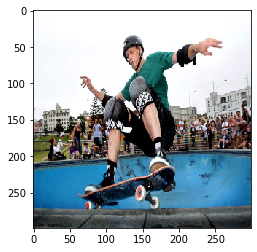

In [28]:
plt.imshow(img)

In [29]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a skateboarder is doing a trick on a skateboard .
a skateboarder doing a trick on a ramp .
a person on a skateboard doing a trick on a ramp .
a man riding a skateboard down a ramp .
a person jumping up a ramp on a ramp .
a skateboarder is doing a trick on a skateboard .
a skateboarder is doing a trick on a skateboard .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a person on a skateboard doing a trick on a ramp .


In [30]:
!wget https://static.euronews.com/articles/272220/1280x720_272220.jpg -O data/human_robot.jpg
!wget https://img.youtube.com/vi/CljILpVth-A/hqdefault.jpg -O data/dancing_cat.jpg
!wget https://assets.atlasobscura.com/media/W1siZiIsInVwbG9hZHMvcGxhY2VfaW1hZ2VzLzI5MTdmNGRiYmY5NTBjYzFlYl8xNTc2ODQzMDgxNF9mY2ZjMTk1NTI4X28uanBnIl0sWyJwIiwidGh1bWIiLCJ4MzkwPiJdLFsicCIsImNvbnZlcnQiLCItcXVhbGl0eSA4MSAtYXV0by1vcmllbnQiXV0 -O data/riverhouse.jpg
!wget https://www.mensjournal.com/wp-content/uploads/2015/07/Unknown-21.jpeg -O data/riverbaidarka.jpg
!wget https://www.vettedpetcare.com/vetted-blog/wp-content/uploads/2018/05/should-cats-eat-fish-square.jpeg -O data/cat_and_fish.jpg
!wget https://fluffykitt.com/wp-content/uploads/2019/01/Can-Cats-Eat-Fish-696x465.jpg -O data/cat_eating_fish.jpg
!wget https://images.frandroid.com/wp-content/uploads/2017/11/roadster_front_58-1000x563.jpg -O data/tesla.jpg
!wget https://img.resized.co/spin1038/eyJkYXRhIjoie1widXJsXCI6XCJodHRwczpcXFwvXFxcL21lZGlhLnJhZGlvY21zLm5ldFxcXC91cGxvYWRzXFxcL2NvbnRlbnRcXFwvMDAwXFxcL2ltYWdlc1xcXC8wMDAyNDhcXFwvMjU1NzM1XzU0X25ld3NfaHViXzIwODgwMF82NTZ4NTAwLmpwZ1wiLFwid2lkdGhcIjo5NzAsXCJoZWlnaHRcIjo0ODUsXCJkZWZhdWx0XCI6XCJodHRwczpcXFwvXFxcL3d3dy5zcGluMTAzOC5jb21cXFwvaW1hZ2VzXFxcL25vLWltYWdlLnBuZ1wifSIsImhhc2giOiIwN2Y4NjhiMjU4ZGUxYTAyNDJhZDVhZTJiMGRlOGYwYTZlNzI3ZDNiIn0=/these-dogs-playing-tennis-is-the-cutest-thing-you-39-ll-see-today.jpg -O data/dog_tennis.jpg
!wget https://eusp.org/sites/default/files/styles/item_full_xxs_max/public/news/preview/2019/211216eusp55.jpg?itok=mVXE8uBr -O data/bg.jpg
!wget https://fashionhot.ru/wp-content/uploads/2019/10/1-2.jpg -O data/room.jpg
!wget https://fs.kinomania.ru/file/news/8/bf/8bf1e5954737835c2c2bb65bb94b19b7.jpeg -O data/vyazov.jpg

--2020-05-08 21:12:38--  https://static.euronews.com/articles/272220/1280x720_272220.jpg
Resolving static.euronews.com (static.euronews.com)... 8.247.202.122, 8.247.205.250, 8.250.155.242
Connecting to static.euronews.com (static.euronews.com)|8.247.202.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168414 (164K) [image/jpeg]
Saving to: ‘data/human_robot.jpg’

data/human_robot.jp 100%[===================>] 164,47K  --.-KB/s    in 0,1s    

2020-05-08 21:12:38 (1,13 MB/s) - ‘data/human_robot.jpg’ saved [168414/168414]

--2020-05-08 21:12:38--  https://img.youtube.com/vi/CljILpVth-A/hqdefault.jpg
Resolving img.youtube.com (img.youtube.com)... 216.58.209.238, 216.58.204.110, 216.58.198.206, ...
Connecting to img.youtube.com (img.youtube.com)|216.58.209.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12973 (13K) [image/jpeg]
Saving to: ‘data/dancing_cat.jpg’

data/dancing_cat.jp 100%[===================>]  12,67K  --.-KB/s    in 

a woman holding a cell phone and a man holding a cell phone .
a man with a cell phone and a woman in a black jacket .
a man is holding a cell phone with a woman .
a woman holding a cell phone with a woman in front of a cake .
a woman holding a cell phone with a man in a mask .
a woman with a cell phone with a knife .
a man with a beard with a dog and a woman .
a woman holding a cell phone with a man in front of a man .
a woman holding a cell phone and a woman in a black shirt .
a woman holding a cell phone with a cake .


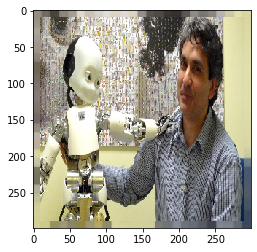

In [31]:
 # apply your network on images you've found
img = plt.imread('data/human_robot.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a cat is standing in the middle of a white and blue sky .
a cat is standing on a blue surface .
a cat is sitting on a blue and white cat .
a cat is standing on a blue surface .
a cat is standing in the middle of a blue and white cat .
a cat is standing on a blue surface .
a cat is sitting on a white surface .
a cat is sitting on a table .
a cat is sitting on a window sill .
a cat is sitting on a blue surface .


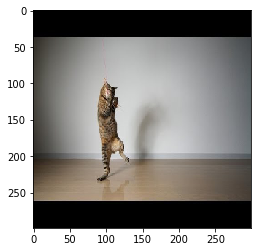

In [32]:
img = plt.imread('data/dancing_cat.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a small boat is in the water near a body of water .
a large boat with a bridge over a body of water .
a boat is on a river near a body of water .
a large boat with a bunch of water and a body of water .
a large boat with a small boat in the background .
a large boat is on the side of a river .
a large boat is on a river near a body of water .
a large boat with a bridge over a body of water .
a large boat with a large body of water .
a large boat on a river near a river .


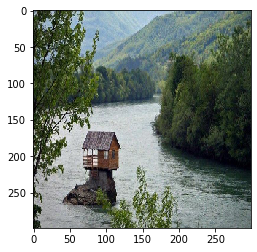

In [33]:
img = plt.imread('data/riverhouse.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a boat is floating in the water near a body of water .
a boat is docked in the water near a body of water .
a boat floating in a body of water .
a boat is floating on the water near a body of water .
a boat is docked in the water and a boat .
a boat is floating on the water near a body of water .
a boat is floating in the water at a dock .
a boat is sitting on the water near a body of water .
a boat is docked in the water near a body of water .
a boat is on the water near a body of water .


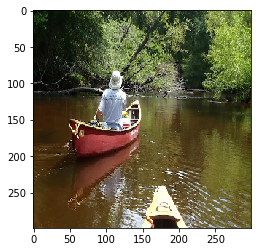

In [34]:
img = plt.imread('data/riverbaidarka.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a cat is sitting on a table with a cat .
a cat sitting on a table with a chair .
a cat sitting on a table with a cat .
a cat sitting on a table with a cat .
a cat sitting on a table with a cat .
a cat sitting on a table with a cat .
a cat sitting on a chair looking at the camera .
a cat sitting on a chair with a cat .
a cat sitting on a table with a cat .
a cat sitting on a table with a cat .


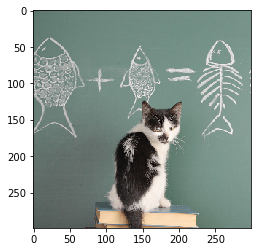

In [35]:
img = plt.imread('data/cat_and_fish.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a cat is sitting on a table next to a window .
a cat sitting on a table with a cat in the background .
a cat is sitting on a couch next to a window .
a cat is sitting on a table with a cat .
a cat is sitting on a chair next to a window .
a cat sitting on a chair looking at a window .
a cat is sitting on a chair looking out of a window .
a cat is sitting on a table with a cat .
a cat is sitting on a table with a cat .
a cat is sitting in a chair looking at a cat .


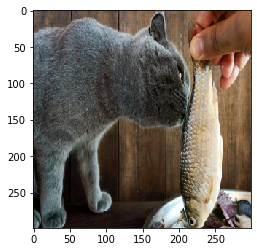

In [36]:
img = plt.imread('data/cat_eating_fish.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a red car is parked on the side of a road .
a car that is parked on the side of a road .
a red car is parked next to a car .
a car that is sitting on a street .
a red car parked on the side of a road .
a car that is parked on the side of a road .
a red car with a red car on the side of a road .
a red car is parked next to a car .
a black and white car with a car on the side of the road .
a car with a black and white dog on a car .


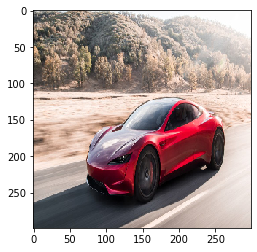

In [37]:
img = plt.imread('data/tesla.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a young boy holding a tennis racquet on a court .
a young boy holding a tennis racket in her hand .
a young girl holding a tennis racket and a woman .
a woman holding a tennis racket in her hand .
a young boy holding a tennis racquet on a court .
a young boy holding a tennis racket in her hand .
a young boy holding a tennis racquet on a court .
a young boy holding a tennis racket and a woman .
a man holding a tennis racquet on a court .
a young boy holding a tennis racket in her hand .


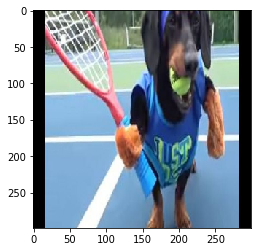

In [38]:
img = plt.imread('data/dog_tennis.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man wearing a tie and a tie .
a man wearing a tie and a tie .
a man wearing a tie and a tie .
a man wearing a suit and tie with a tie .
a man wearing a tie and a tie .
a man wearing a hat and a tie .
a man wearing a suit and tie with a cell phone .
a man wearing a suit and tie with a microphone .
a man wearing a tie and a tie .
a man wearing a suit and tie with a microphone .


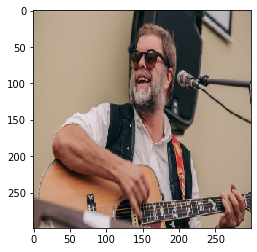

In [39]:
img = plt.imread('data/bg.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a bed with a bed , a window and a window .
a bed with a bed , a window and a window .
a bed with a bed , a window , and a window .
a bedroom with a bed and a bed in a room .
a hotel room with a bed , a couch , and a television .
a bed with a bed , a window and a window .
a bedroom with a bed and a large bed .
a bedroom with a bed and a large bed .
a large bed with a bed and a window .
a bed with a bed and a window .


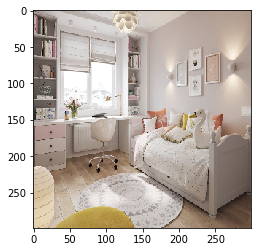

In [40]:
img = plt.imread('data/room.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man wearing a hat and a hat is holding a cell phone .
a man is wearing a hat and a hat .
a man wearing a hat and a hat is wearing a hat .
a man wearing a hat and a hat is holding a cell phone .
a man wearing a hat and a hat hat and a hat .
a man wearing a hat and a hat is holding a cell phone .
a man wearing a hat and a hat is holding a cell phone .
a man wearing a hat and a hat is holding a cell phone .
a man wearing a hat and a hat is holding a cell phone .
a man with a hat and a hat is holding a cell phone .


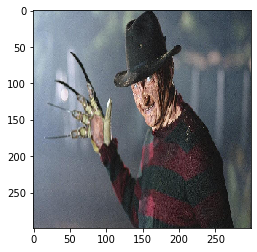

In [41]:
img = plt.imread('data/vyazov.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.
plt.imshow(img)
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

### What else to try

If you're made it this far you're awesome and you should know it already. All the tasks below are completely optional and may take a lot of your time. Proceed at your own risk

#### Hard attention

* There are more ways to implement attention than simple softmax averaging. Here's [a lecture](https://www.youtube.com/watch?v=_XRBlhzb31U) on that. 
* We recommend you to start with [gumbel-softmax](https://blog.evjang.com/2016/11/tutorial-categorical-variational.html) or [sparsemax](https://arxiv.org/abs/1602.02068) attention.

#### Reinforcement learning

* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week7](https://github.com/yandexdataschool/Practical_RL/tree/spring19/week7_seq2seq)
* Theory: https://arxiv.org/abs/1612.00563

#### Chilling out

This is the final and the most advanced task in the DL course. And if you're doing this with the on-campus YSDA students, it should be late spring by now. There's got to be a better way to spend a few days than coding another deep learning model. If you have no idea what to do, ask Yandex. Or your significant other.

![img](https://imgs.xkcd.com/comics/computers_vs_humans.png)